In [1]:

%matplotlib widget
import matplotlib
# List all paths in data folder
import os
data_dir = "C:/Users/gator/OneDrive - University of Florida/10x images for quantification/Manual Counts"
file_names = []
for file_name in os.listdir(data_dir):
    file_names.append(file_name)
    print(file_name)

1sAc2r1 PM NEUN DW.roi
1sAc2r1 PM NEUN.tif
1sAc4r3 PM NEUN DW.roi
1sAc4r3 PM NEUN.tif
2sAc4r5 PM NEUN AF.roi
2sAc4r5 PM NEUN DW.roi
2sAc4r5 PM NEUN.tif
2sBc4r1 PM NEUN.tif
2sBc5r3 PM NEUN.tif
2sCc1r1 PM NEUN.tif
3sAc2r3 PM NEUN.tif
3sAc3r2 PM NEUN AF.roi
3sAc3r2 PM NEUN.tif
3sBc1r2 PM NEUN.tif
4sBc1r2 PM NEUN AF.roi
4sBc1r2 PM NEUN.tif


In [2]:

from roifile import ImagejRoi
annotation_dict = {}
for file_name in file_names:
    if(".roi" in file_name):
        file_name_n_ext = file_name.split(".")[0]
        file_name_split = file_name_n_ext.split(" ")
        annotator = file_name_split[-1]
        stain = file_name_split[-2]
        image_id = file_name_split[0]
        image_name = image_id + " " + file_name_split[1] + " " + stain
        roi = ImagejRoi.fromfile(data_dir + "/" + file_name)
        if image_name not in annotation_dict.keys():
            annotation_dict[image_name] = {}
            annotation_dict[image_name]["annotators"] = []
            annotation_dict[image_name]["rois"] = []
        annotation_dict[image_name]["annotators"].append(annotator)
        annotation_dict[image_name]["rois"].append(roi)
print(annotation_dict)

{'1sAc2r1 PM NEUN': {'annotators': ['DW'], 'rois': [<ImagejRoi '1sAc2r1 PM NEUN DW'>]}, '1sAc4r3 PM NEUN': {'annotators': ['DW'], 'rois': [<ImagejRoi '1sAc4r3 PM NEUN DW'>]}, '2sAc4r5 PM NEUN': {'annotators': ['AF', 'DW'], 'rois': [<ImagejRoi '2sAc4r5 PM NEUN AF'>, <ImagejRoi '2sAc4r5 PM NEUN DW'>]}, '3sAc3r2 PM NEUN': {'annotators': ['AF'], 'rois': [<ImagejRoi '3sAc3r2 PM NEUN AF'>]}, '4sBc1r2 PM NEUN': {'annotators': ['AF'], 'rois': [<ImagejRoi '4sBc1r2 PM NEUN AF'>]}}


1sAc2r1 PM NEUN {'annotators': ['DW'], 'rois': [<ImagejRoi '1sAc2r1 PM NEUN DW'>]}
[[]]
1sAc4r3 PM NEUN {'annotators': ['DW'], 'rois': [<ImagejRoi '1sAc4r3 PM NEUN DW'>]}
[[]]
2sAc4r5 PM NEUN {'annotators': ['AF', 'DW'], 'rois': [<ImagejRoi '2sAc4r5 PM NEUN AF'>, <ImagejRoi '2sAc4r5 PM NEUN DW'>]}
[[[825.8333740234375, 987.8333129882812], [728.5, 2149.166748046875], [1622.5, 1623.5], [1700.16650390625, 1732.166748046875], [1329.0, 1890.0], [1358.0, 2011.0], [806.5, 1125.8333740234375], [835.8333740234375, 2283.5], [794.1666259765625, 2381.5], [746.5, 1184.8333740234375], [800.833251953125, 1324.5], [854.1666259765625, 1301.8333740234375], [441.16668701171875, 1299.8333740234375], [433.5, 1414.5], [423.5, 1340.5], [430.5, 1242.5], [546.8333129882812, 1035.8333740234375], [529.0, 1234.5], [657.5, 1158.5], [565.5, 1051.0], [479.16668701171875, 1085.1666259765625], [608.0, 2051.5], [716.5, 2314.25], [735.0, 2328.25], [692.75, 1926.0], [681.25, 1933.5], [747.25, 2161.0], [1104.8333740234375

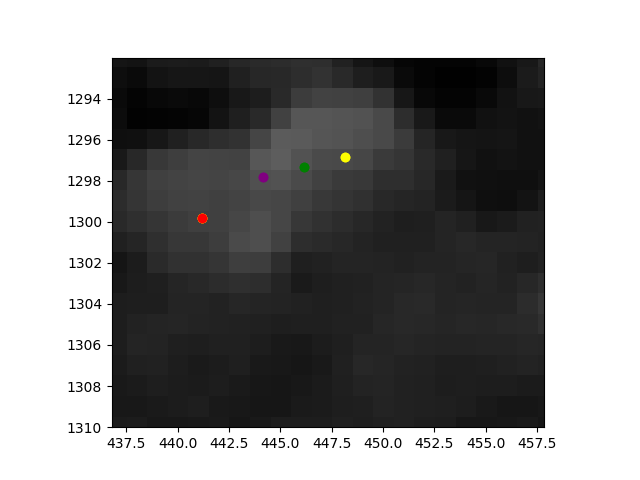

3sAc3r2 PM NEUN {'annotators': ['AF'], 'rois': [<ImagejRoi '3sAc3r2 PM NEUN AF'>]}
[[]]
4sBc1r2 PM NEUN {'annotators': ['AF'], 'rois': [<ImagejRoi '4sBc1r2 PM NEUN AF'>]}
[[]]


In [4]:
import math
from matplotlib import pyplot as plt
from skimage import io
import copy

min_required_distance = 20
min_agreeance = 0.5
for idx, (image_name, annotators) in enumerate(annotation_dict.items()):
    compiled_coords = []
    for annotator, roi in list(zip(annotators["annotators"],annotators["rois"])):
        compiled_coords.append(roi.coordinates().tolist())
    print(image_name, annotators)
    coord_matches = []
    temp_coords = copy.deepcopy(compiled_coords)
    annotator_index = 0
    coord_index = 0
    for i in range(len(temp_coords)):
        coord_matches.append([])
    while(coord_index<len(temp_coords[annotator_index])):
        current_cord = temp_coords[annotator_index][coord_index]
        match = [current_cord]
        match_indexes = [coord_index]
        match_count = 1
        for index_offset in range(len(temp_coords)-1):
            other_annotator_index = annotator_index+index_offset+1
            if(other_annotator_index>len(temp_coords)-1):
                other_annotator_index -= len(temp_coords)
            
            min_distance = 100000000
            min_coord = []
            min_coord_idx = 0
            for idx, other_coord in enumerate(temp_coords[other_annotator_index]):
                distance_to_coord = math.sqrt(math.pow(other_coord[0]-current_cord[0],2) + math.pow(other_coord[1]-current_cord[1],2))
                if(distance_to_coord<min_distance):
                    min_distance = distance_to_coord
                    min_coord = other_coord
                    min_coord_idx = idx
            if(min_distance<min_required_distance):
                match_count+=1
                match.append(min_coord)
                match_indexes.append(min_coord_idx)
            else:
                match.append([])
                match_indexes.append(None)

        if(match_count/len(temp_coords)>min_agreeance):
            coord_matches[annotator_index].append(match)
            for index_offset in range(len(temp_coords)):
                other_annotator_index = annotator_index+index_offset
                if(other_annotator_index>len(temp_coords)-1):
                    other_annotator_index -= len(temp_coords)
                temp_coords[other_annotator_index].pop(match_indexes[index_offset])
        else:
            coord_index+=1
    print(temp_coords)
    if(len(temp_coords)>1):
        image = io.imread(data_dir + "/" + image_name + ".tif")
        plt.imshow(image)
        print(len(temp_coords[annotator_index]))
        print(len(compiled_coords[annotator_index]))
        print(len(temp_coords[annotator_index+1]))
        plt.scatter([match[0] for match in compiled_coords[annotator_index]],[match[1] for match in compiled_coords[annotator_index]], marker='o', color="yellow")
        plt.scatter([match[0] for match in compiled_coords[annotator_index+1]],[match[1] for match in compiled_coords[annotator_index+1]], marker='o', color="purple")
        plt.scatter([(match[0][0]+match[1][0])/2 for match in coord_matches[0]],[(match[0][1]+match[1][1])/2 for match in coord_matches[0]], marker='o', color="green")
        plt.scatter([match[0] for match in temp_coords[annotator_index]],[match[1] for match in temp_coords[annotator_index]], marker='o', color="red")
        plt.scatter([match[0] for match in temp_coords[annotator_index+1]],[match[1] for match in temp_coords[annotator_index+1]], marker='o', color="blue")
        plt.show()
        